In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# Download training data in the "data" folder
training_data = datasets.FashionMNIST(
    root = r"D:\ML\ML for 3D and VFX Course\Week3\dev\data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

# Download test data in the "data" folder
test_data = datasets.FashionMNIST(
    root = r"D:\ML\ML for 3D and VFX Course\Week3\dev\data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [4]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return self.classifier(x)

model = CNN().to(device)
print(model)

CNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
# Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Switch model to train
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        # pred = prediction, y = correct value
        # loss = how far are we from correct value
        loss = loss_fn(pred, y)

        # Gradient descent
        loss.backward()
        # Update the model based on gradient descent
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Switch model to test / evaluate
    model.eval()
    test_loss, correct = 0,0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test error : \n Accuracy : {(100*correct):>0.1f}%, Avg loss : {test_loss:>8f} \n")


In [10]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n ---")
    train(train_dataloader, model, loss_fn, optimizer)
    test(train_dataloader, model, loss_fn)
print("Done")

Epoch 1
 ---
loss: 0.135467 [    0/60000]
loss: 0.268675 [ 6400/60000]
loss: 0.123672 [12800/60000]
loss: 0.260538 [19200/60000]
loss: 0.196017 [25600/60000]
loss: 0.357391 [32000/60000]
loss: 0.234206 [38400/60000]
loss: 0.286093 [44800/60000]
loss: 0.224237 [51200/60000]
loss: 0.190776 [57600/60000]
Test error : 
 Accuracy : 93.6%, Avg loss : 0.169966 

Epoch 2
 ---
loss: 0.194487 [    0/60000]
loss: 0.202613 [ 6400/60000]
loss: 0.136965 [12800/60000]
loss: 0.223566 [19200/60000]
loss: 0.213388 [25600/60000]
loss: 0.313961 [32000/60000]
loss: 0.193165 [38400/60000]
loss: 0.256858 [44800/60000]
loss: 0.230133 [51200/60000]
loss: 0.168074 [57600/60000]
Test error : 
 Accuracy : 93.9%, Avg loss : 0.164011 

Epoch 3
 ---
loss: 0.112735 [    0/60000]
loss: 0.211023 [ 6400/60000]
loss: 0.104233 [12800/60000]
loss: 0.223221 [19200/60000]
loss: 0.124442 [25600/60000]
loss: 0.290542 [32000/60000]
loss: 0.177105 [38400/60000]
loss: 0.292884 [44800/60000]
loss: 0.234192 [51200/60000]
loss: 0.15

In [11]:
# Save the model
class_names = training_data.classes

torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names
}, 'fashion_mnist_base_model.pth')
print("Saved PyTorch Model State to fashion_mnist_base_model.pth")

Saved PyTorch Model State to fashion_mnist_base_model.pth


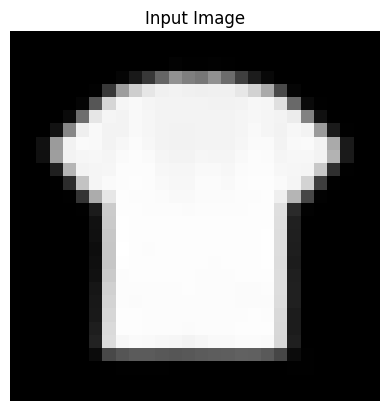

Prediction index: 0
Predicted class: T-shirt/top


In [13]:
# Test with custom image!
model = CNN().to(device)
# Load saved model
loaded_model = torch.load("fashion_mnist_base_model.pth")
model.load_state_dict(loaded_model['model_state_dict'])
model.eval()
class_names = loaded_model['class_names']

from PIL import Image

image_path = "test.jpg"
# Open image and convert to grayscale
image = Image.open(image_path).convert("L")

# Resize the image to 28x28
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

tensor_image = transform(image)
input_tensor = tensor_image.unsqueeze(0).to(device)  # [1, 1, 28, 28]

plt.imshow(tensor_image.squeeze(), cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.show()

with torch.inference_mode():
    output = model(input_tensor)
    # argmax selects the output with highest value
    prediction = torch.argmax(output).item()

class_name = training_data.classes[prediction]
print(f"Prediction index: {prediction}")
print(f"Predicted class: {class_name}")